In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

import matplotlib
matplotlib.rcParams['figure.figsize'] = (13, 5)
sns.set_color_codes('muted')
sns.set_style('ticks', {'axes.grid': 'True'})

# Регрессия

## Генерируем данные

In [2]:
torch.manual_seed(42)

x_train = torch.rand(100)
x_train = x_train * 20.0 - 10.0

y_train = torch.sin(x_train)

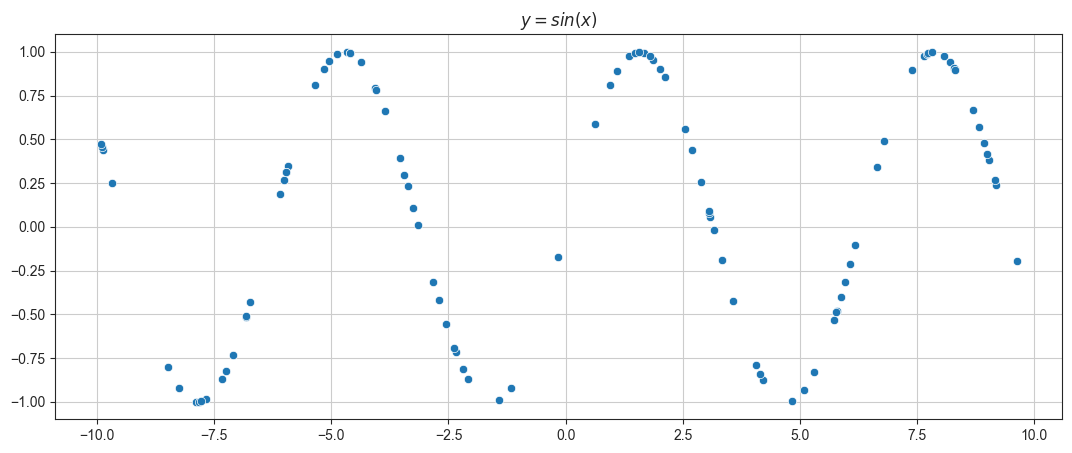

In [3]:
sns.scatterplot(x=x_train.numpy(), y=y_train.numpy())
plt.figure
plt.title('$y = sin(x)$');

Добавим шум:

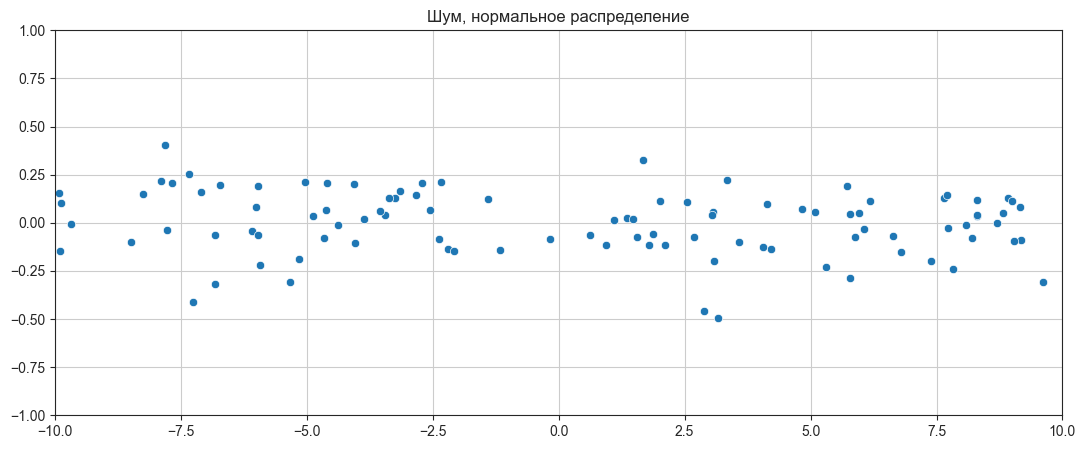

In [4]:
noise = torch.randn(y_train.shape) / 5
sns.scatterplot(x=x_train.numpy(), y=noise.numpy())
plt.axis([-10, 10, -1, 1])
plt.title('Шум, нормальное распределение');

Text(0.5, 1.0, '$y = sin(x)$ с шумом')

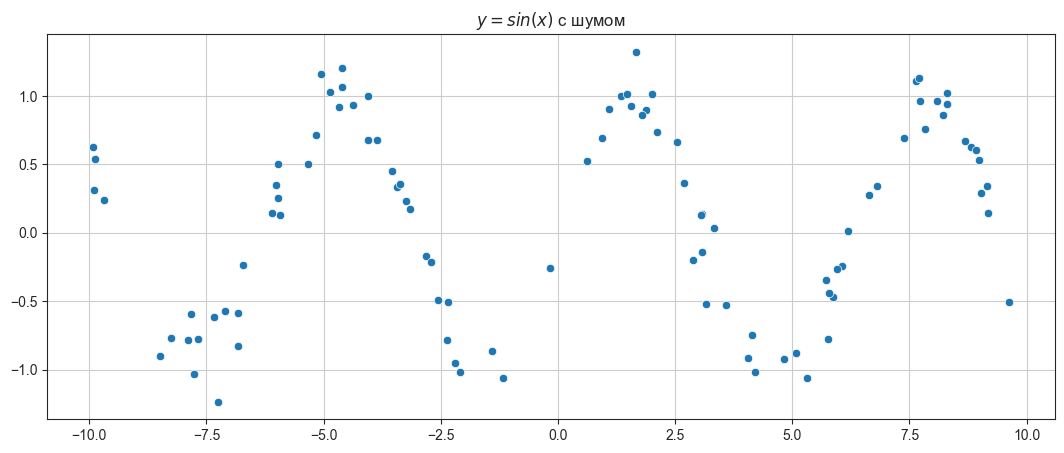

In [5]:
y_train = y_train+noise
sns.scatterplot(x=x_train.numpy(), y=y_train.numpy())
plt.title('$y = sin(x)$ с шумом')

In [6]:
print(x_train.size())
print(y_train.size())

torch.Size([100])
torch.Size([100])


Изменим размерность данных, превратив их в одномерные вектора:

In [7]:
x_train.unsqueeze_(1)
y_train.unsqueeze_(1);

In [8]:
print(x_train.size())
print(y_train.size())

torch.Size([100, 1])
torch.Size([100, 1])


## Датасет для валидации:

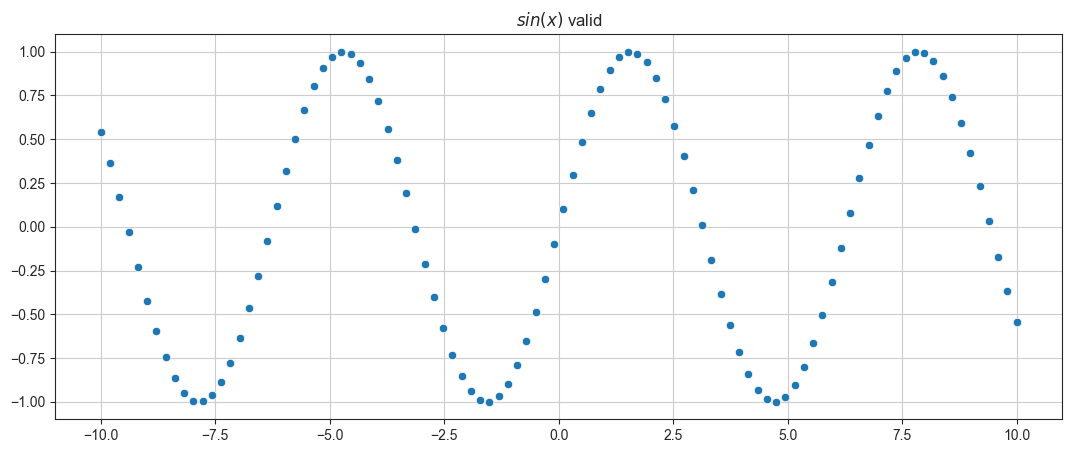

In [9]:
x_validation = torch.linspace(-10, 10, 100)
y_validation = torch.sin(x_validation.data)


sns.scatterplot(x=x_validation.numpy(), y=y_validation.numpy())
plt.title('$ sin(x) $ valid')
plt.show()

In [10]:
print(x_validation.size())
print(y_validation.size())

torch.Size([100])
torch.Size([100])


In [11]:
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1);

In [12]:
print(x_validation.size())
print(y_validation.size())

torch.Size([100, 1])
torch.Size([100, 1])


## Создаем модель

In [13]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

1. fc1 - полносвязный слой (линейной слой), на вход принимает 1 координату точки, а так же количество скрытых нейронов (выход)
2. act1 - функция активации, в нашем случае сигмоида
3. fc2 - второй полносвязный слой, на входе n скрытых нейронов, на выходе 1 координата y

In [14]:
sine_net = SineNet(50)

## Предсказание

In [15]:
def predict(net, x, y):
    y_pred = net.forward(x)
    
    sns.scatterplot(x=x.squeeze(1), y=y.squeeze(1), label='Valid')
    sns.scatterplot(x=x.squeeze(1), y=y_pred.data.squeeze(1), label='Predicted', color='r')

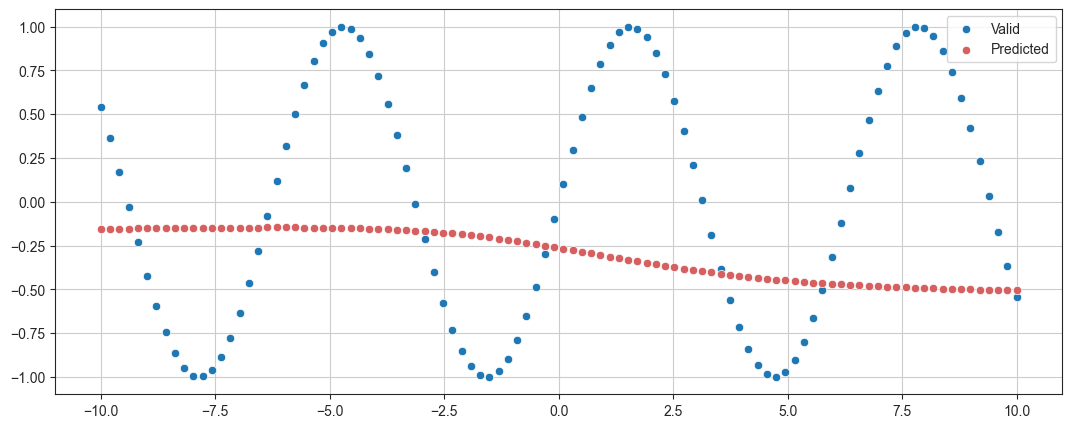

In [16]:
predict(sine_net, x_validation, y_validation)

Оптимизатор:

In [17]:
optimizer = torch.optim.Adam(sine_net.parameters(), lr=0.01)

Лосс-функция:

In [18]:
def loss(pred, target):
    squares = (pred - target) ** 2
    return squares.mean()

Обучение:

In [19]:
%%time
for epoch_index in range(2000):
    optimizer.zero_grad()

    y_pred = sine_net.forward(x_train)
    loss_val = loss(y_pred, y_train)

    loss_val.backward()

    optimizer.step()

CPU times: user 729 ms, sys: 9.75 ms, total: 739 ms
Wall time: 740 ms


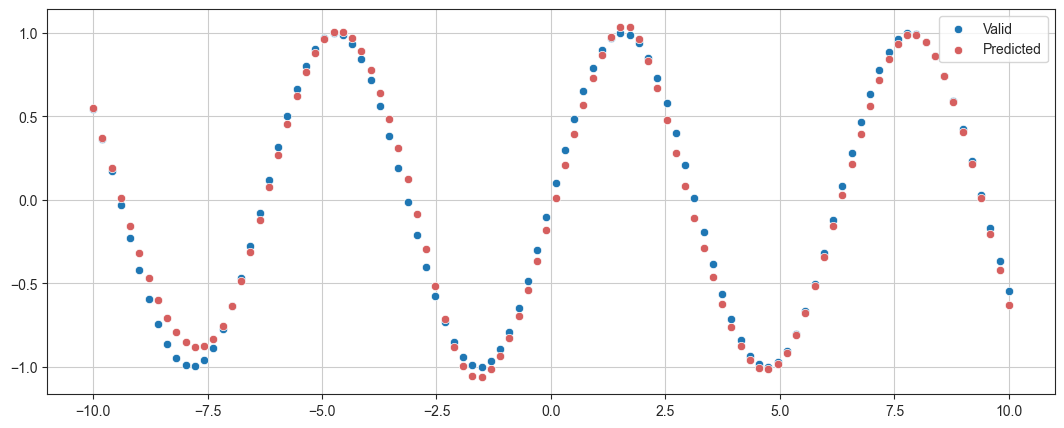

In [20]:
predict(sine_net, x_validation, y_validation)

___

Другая функция:

In [21]:
def target_function(x):
    return 2**x * torch.sin(2**-x)

x_train =  torch.linspace(-10, 5, 100)
y_train = target_function(x_train)
noise = torch.randn(y_train.shape) / 20.
y_train = y_train + noise
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)

x_validation = torch.linspace(-10, 5, 100)
y_validation = target_function(x_validation)
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1);

In [22]:
class RegressionNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(RegressionNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

In [23]:
net = RegressionNet(100)

In [24]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.03)

In [25]:
def loss(pred, target):
    return (pred-target).abs().mean()

In [26]:
for epoch_index in range(2000):
    optimizer.zero_grad()
    y_pred = net.forward(x_train)
    
    
    loss_val = loss(y_pred, y_train)
    loss_val.backward()
    
    optimizer.step()

In [27]:
def metric(pred, target):
    return (pred - target).abs().mean()

In [28]:
def predict(net, x, y):
    y_pred = net.forward(x)
    
    sns.scatterplot(x=x.squeeze(1), y=y.squeeze(1), label='Valid')
    sns.scatterplot(x=x.squeeze(1), y=y_pred.data.squeeze(1), label='Predicted', color='r')

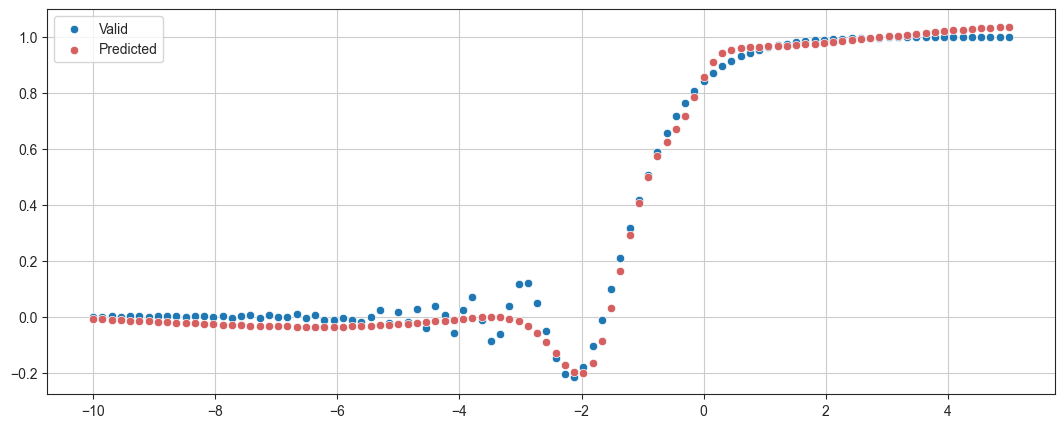

In [29]:
predict(net, x_validation, y_validation)

# Классификация

In [30]:
random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [32]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        #self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        #self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        #x = self.fc2(x)
        #x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

In [33]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

In [34]:
batch_size = 10

for epoch in range(5000):
    #Каждую эпоху перемешиваем порядок индексов
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
    
    #Каждые 100 эпох вычисляем метрики
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        print('Эпоха', epoch ,(test_preds == y_test).float().mean())

Эпоха 0 tensor(0.3519)
Эпоха 100 tensor(0.4815)
Эпоха 200 tensor(0.4815)
Эпоха 300 tensor(0.4815)
Эпоха 400 tensor(0.5000)
Эпоха 500 tensor(0.6296)
Эпоха 600 tensor(0.5926)
Эпоха 700 tensor(0.7593)
Эпоха 800 tensor(0.7778)
Эпоха 900 tensor(0.7963)
Эпоха 1000 tensor(0.8333)
Эпоха 1100 tensor(0.7963)
Эпоха 1200 tensor(0.8148)
Эпоха 1300 tensor(0.7778)
Эпоха 1400 tensor(0.8148)
Эпоха 1500 tensor(0.8148)
Эпоха 1600 tensor(0.8333)
Эпоха 1700 tensor(0.8148)
Эпоха 1800 tensor(0.8148)
Эпоха 1900 tensor(0.8333)
Эпоха 2000 tensor(0.8333)
Эпоха 2100 tensor(0.8333)
Эпоха 2200 tensor(0.8519)
Эпоха 2300 tensor(0.8333)
Эпоха 2400 tensor(0.8519)
Эпоха 2500 tensor(0.8519)
Эпоха 2600 tensor(0.8704)
Эпоха 2700 tensor(0.8889)
Эпоха 2800 tensor(0.8704)
Эпоха 2900 tensor(0.8704)
Эпоха 3000 tensor(0.8889)
Эпоха 3100 tensor(0.9074)
Эпоха 3200 tensor(0.9074)
Эпоха 3300 tensor(0.9074)
Эпоха 3400 tensor(0.9074)
Эпоха 3500 tensor(0.8889)
Эпоха 3600 tensor(0.9074)
Эпоха 3700 tensor(0.9074)
Эпоха 3800 tensor(0.9074

/Users/lefantino/opt/anaconda3/envs/pet_projects_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/var/folders/tt/6wgs8wdx3h365dwt19nvpfqm0000gn/T/ipykernel_8707/2529696004.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  plt.scatter(X_train[indexes, 0],


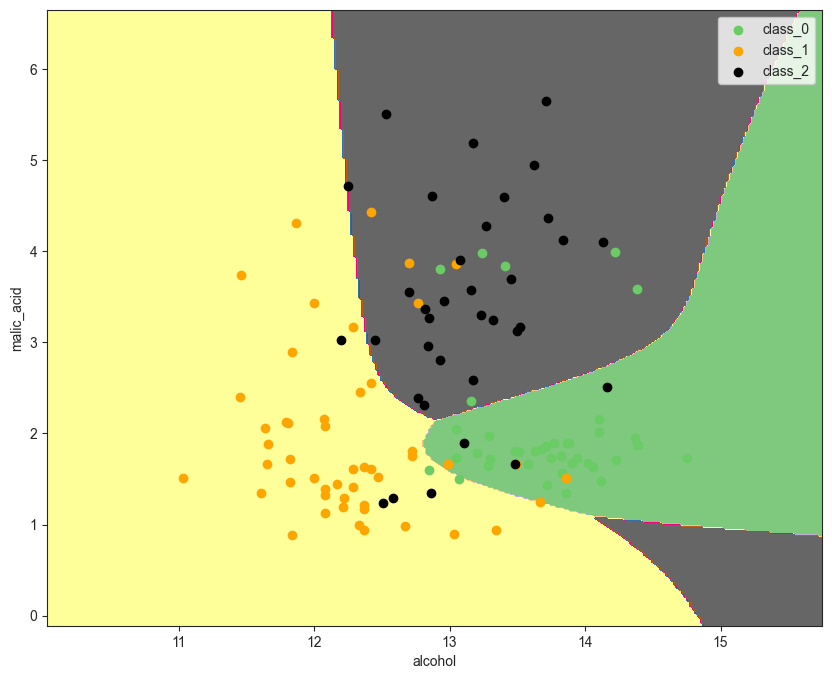

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()